In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Task 1: Data Understanding and Visualization:**

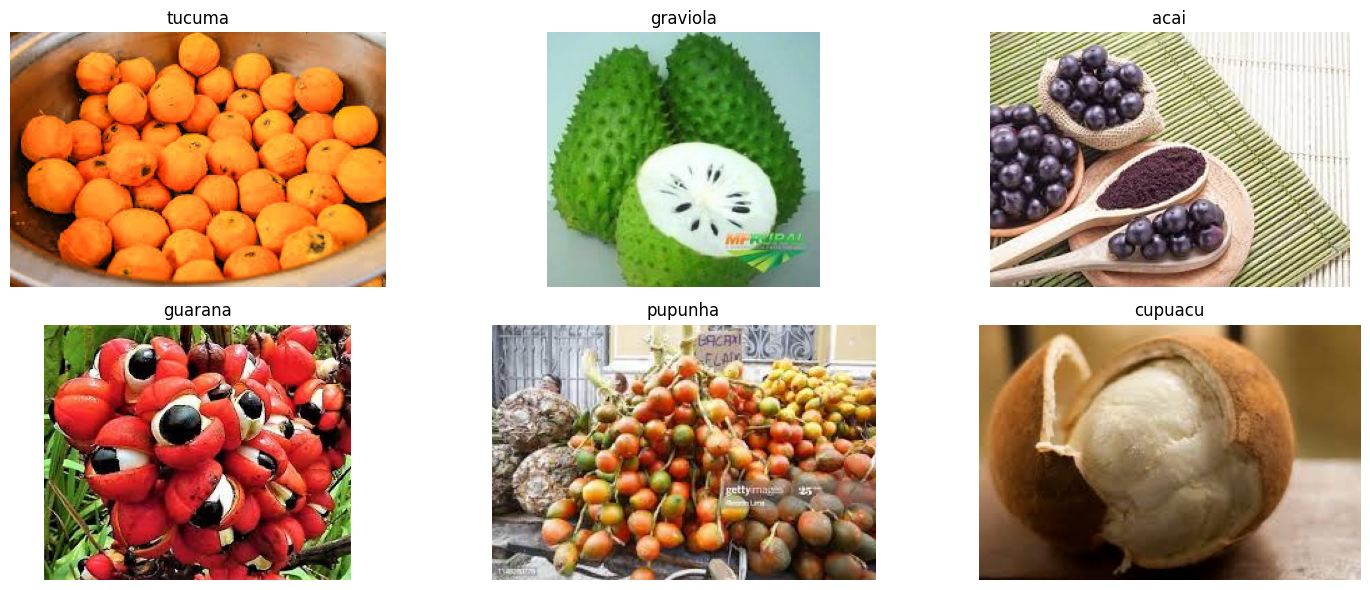

In [2]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Paths to train and test directories
train_dir = "/content/drive/MyDrive/FruitinAmazon/train/"
test_dir = "/content/drive/MyDrive/FruitinAmazon/test/"

# Get class names (subdirectory names)
class_names = os.listdir(train_dir)

# Select one random image from each class
selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        images = os.listdir(class_path)
        if images:
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            selected_images.append(img)
            selected_labels.append(class_name)

# Plot images in a grid with two rows
num_classes = len(selected_images)
cols = min(3, num_classes)
rows = (num_classes + cols - 1) // cols  # Compute number of rows

plt.figure(figsize=(15, 6))
for i, img in enumerate(selected_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(selected_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
from PIL import Image
# List of corrupted images
corrupted_images = []

# Iterate through class subdirectories
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify if the image is corrupted
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)  # Remove corrupted image
                print(f"Removed corrupted image: {image_path}")

# Print final report
if not corrupted_images:
    print("No corrupted images found.")
else:
    print(f"Total corrupted images removed: {len(corrupted_images)}")


No corrupted images found.


**Task 2: Loading and Preprocessing Image Data in keras:**

In [4]:
import tensorflow as tf

# Define image size and batch size
img_height = 128  # Reshape to image height
img_width = 128   # Reshape to image width
batch_size = 32
validation_split = 0.2  # 80% training, 20% validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]

# Load training dataset (before normalization)
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Store class names before mapping
class_names = train_ds_raw.class_names
print(f"Classes: {class_names}")

# Apply the normalization (Rescaling) to the training dataset
train_ds = train_ds_raw.map(lambda x, y: (rescale(x), y))

# Load validation dataset (before normalization)
val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds_raw.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Found 90 files belonging to 6 classes.
Using 18 files for validation.


**Task 3 - Implement a CNN with**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# Define CNN Model
model = keras.Sequential([

    # Convolutional Layer 1
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu", input_shape=(128, 128, 3)),

    # Pooling Layer 1
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Convolutional Layer 2
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),

    # Pooling Layer 2
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    # Flatten Layer
    layers.Flatten(),

    # Fully Connected Layers (Hidden Layers)
    layers.Dense(64, activation="relu"),
    layers.Dense(128, activation="relu"),

    # Output Layer (Softmax for multi-class classification)
    layers.Dense(len(class_names), activation="softmax")
])

# Compile Model
model.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

**Task 4: Compile the Model**

In [9]:
# Compile the CNN Model
model.compile(
    optimizer="sgd",  # Optimizer
    loss="sparse_categorical_crossentropy",  # Loss Function
    metrics=["accuracy"]  # Evaluation Metric
)

print("Model compiled successfully!")

Model compiled successfully!


**Task 4: Train the Model**

In [10]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5",  # Save the best model
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,  # Stop training if no improvement for 10 epochs
        monitor="val_loss",
        mode="min",
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=16,
    epochs=250,
    callbacks=callbacks
)

print("Model training completed!")

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.1285 - loss: 1.8012

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 677ms/step - accuracy: 0.1380 - loss: 1.7998 - val_accuracy: 0.0000e+00 - val_loss: 1.8553
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.1762 - loss: 1.7658 - val_accuracy: 0.0000e+00 - val_loss: 1.8482
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step - accuracy: 0.2196 - loss: 1.7554 - val_accuracy: 0.0000e+00 - val_loss: 1.9952
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.1904 - loss: 1.7418

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.1879 - loss: 1.7476 - val_accuracy: 0.1111 - val_loss: 1.7937
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 792ms/step - accuracy: 0.2717 - loss: 1.7604 - val_accuracy: 0.0000e+00 - val_loss: 1.8945
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 827ms/step - accuracy: 0.2812 - loss: 1.7151

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2734 - loss: 1.7154 - val_accuracy: 0.3889 - val_loss: 1.6877
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3906 - loss: 1.6966 - val_accuracy: 0.0000e+00 - val_loss: 2.0934
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 537ms/step - accuracy: 0.1918 - loss: 1.7136 - val_accuracy: 0.0000e+00 - val_loss: 1.9864
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 0.2109 - loss: 1.7318 - val_accuracy: 0.2222 - val_loss: 1.7765
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.3142 - loss: 1.6467 - val_accuracy: 0.2222 - val_loss: 1.7707
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.3426 - loss: 1.6560

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.3576 - loss: 1.6577 - val_accuracy: 0.8333 - val_loss: 1.5214
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 790ms/step - accuracy: 0.3724 - loss: 1.6587 - val_accuracy: 0.3333 - val_loss: 1.6590
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - accuracy: 0.3012 - loss: 1.5520 - val_accuracy: 0.4444 - val_loss: 1.6300
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.4705 - loss: 1.5415 - val_accuracy: 0.8333 - val_loss: 1.3261
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - accuracy: 0.4362 - loss: 1.5287 - val_accuracy: 0.2222 - val_loss: 1.8616
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.4379 - loss: 1.5071 - val_accuracy: 0.4444 - val_loss: 1.6043
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.5061 - loss: 1.4398 - val_accuracy: 0.3889 - val_loss: 1.2579
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 822ms/step - accuracy: 0.5039 - loss: 1.4225 - val_accuracy: 0.0000e+00 - va

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.7747 - loss: 0.5994 - val_accuracy: 0.9444 - val_loss: 0.4430
Epoch 43/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.8837 - loss: 0.4997 - val_accuracy: 0.0556 - val_loss: 4.7764
Epoch 44/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 530ms/step - accuracy: 0.6046 - loss: 1.4044 - val_accuracy: 0.7778 - val_loss: 1.2082
Epoch 45/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.7569 - loss: 0.7624 - val_accuracy: 0.8889 - val_loss: 0.5819
Epoch 46/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 741ms/step - accuracy: 0.9223 - loss: 0.4001 - val_accuracy: 0.7778 - val_loss: 0.9372
Epoch 47/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 789ms/step - accuracy: 0.8850 - loss: 0.4722 - val_accuracy: 0.3333 - val_loss: 1.5099
Epoch 48/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 539ms/step - accuracy: 0.7561 - loss: 0.5847 - val_accuracy: 0.7222 - val_loss: 1.2980
Epoch 49/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.8216 - loss: 0.6135 - val_accuracy: 0.4444 - val_lo

**Task 5: Evaluate the Model**

In [11]:
# Define image size and batch size (same as used during training)
img_height = 128
img_width = 128
batch_size = 16

# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Directory containing the test images
    labels='inferred',  # Automatically assign labels based on subdirectory names
    label_mode='int',  # Labels as integers
    image_size=(img_height, img_width),  # Resize images to the same size
    batch_size=batch_size,  # Set batch size
    shuffle=False  # No need to shuffle for evaluation
)

# Optionally, apply the same normalization (Rescaling) to the test dataset
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]
test_ds = test_ds.map(lambda x, y: (rescale(x), y))  # Apply normalization

Found 30 files belonging to 6 classes.


In [12]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print test results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4556 - loss: 1.5116
Test Accuracy: 43.33%
Test Loss: 1.5341


**Task 6: Save and Load the Model**

In [13]:
# Save the trained model to an .h5 file
model.save('fruit_classification_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [14]:
# Load the saved model from the .h5 file
loaded_model = tf.keras.models.load_model('fruit_classification_model.h5')
print(" Model loaded successfully!")

 Model loaded successfully!


In [15]:
# Evaluate the loaded model on the test dataset
test_loss, test_accuracy = loaded_model.evaluate(test_ds)

# Print test results for the loaded model
print(f"Test Accuracy (Loaded Model): {test_accuracy * 100:.2f}%")
print(f"Test Loss (Loaded Model): {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.4556 - loss: 1.5116
Test Accuracy (Loaded Model): 43.33%
Test Loss (Loaded Model): 1.5341


**Task 7: Predictions and Classification Report**

In [16]:
from sklearn.metrics import classification_report
import numpy as np

# Get class names from the directories (subdirectories in the 'Train' directory)
class_names = sorted(os.listdir(train_dir))  # Assuming 'train_dir' is the path to your training data folder

# Step 1: Make predictions on the test dataset
test_predictions = model.predict(test_ds)

# Convert predictions from probabilities to class labels (integer labels)
predicted_labels = np.argmax(test_predictions, axis=-1)

# Step 2: Get true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Step 3: Generate the Classification Report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Classification Report:
              precision    recall  f1-score   support

        acai       0.67      0.40      0.50         5
     cupuacu       0.40      0.40      0.40         5
    graviola       0.67      0.80      0.73         5
     guarana       1.00      0.20      0.33         5
     pupunha       1.00      0.20      0.33         5
      tucuma       0.21      0.60      0.32         5

    accuracy                           0.43        30
   macro avg       0.66      0.43      0.43        30
weighted avg       0.66      0.43      0.43        30



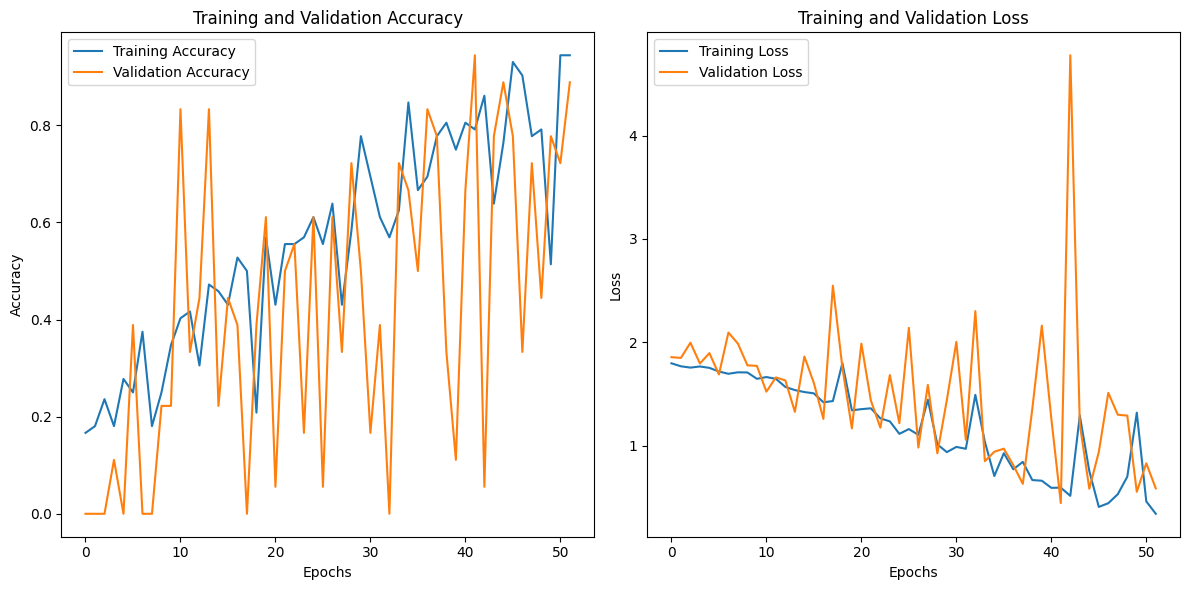

In [17]:
import matplotlib.pyplot as plt

# Assuming you already have the `history` object from model training
# history = model.fit(...)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()